In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as scysig
import scipy.special as scyspe
import scipy.integrate as scyint
import pandas as pds
from IPython.display import Latex

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.output_prompt').css("color","#FFFFFF");
 $('div.input').hide();
 } else {
 $('div.output_prompt').css("color","#8b0000");
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>''')
#<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

# Estimative of Beam Divergence Increase due to Metallic foil

#### An idea of separating the vacuum of the storage ring and the transport line was suggested, in order to facilitate the design for the injection Septum. This can be achieved putting one thin metallic foil in the end of the the transport line and at the beggining of the storage ring vacuum chamber.  In this work we will try to estimate the effect of such windows on the beam parameters. We start by analysing the increase in the angular distribution of the electrons due to multiple scattering by the foils.

We will follow the theory described in the paper:

>Corstens, J.M. et al, An efficient method for calculating plural scattering of relativistic electrons in thin foils and multilayers, NIMB 222 (2004), doi:10.1016/j.nimb.200404.163

According to this reference, we can group the scattering in three types, according to the number of scattering events ($\lambda$) one electron experiences:

\begin{eqnarray} 
&\lambda  &= 1     &\Rightarrow \text{single scattering}\\
1 < &\lambda &< 20 &\Rightarrow \text{plural scattering}\\
&\lambda &> 20    &\Rightarrow \text{multiple scattering}
\end{eqnarray}

The authors then describe a method for calculating the angular distribution of the scattered electron, assuming the entrance beam divergence is zero. The differential cross section used is the screened Rutherford cross section:

\begin{eqnarray}
\frac{\text{d}\sigma}{\text{d}\Omega} &=& \left(\frac{Ze^2}{2\pi\epsilon_0 p v}\right)^2 \frac{1}{(\chi_\alpha^2 + \theta^2)^2}\\
\sigma &=& \left(\frac{Ze^2}{2\pi\epsilon_0pv}\right)^2 \frac{\pi}{\chi_\alpha^2} \quad \text{where} 
\quad \chi_\alpha = \sqrt{1.13 + 3.76\eta^2}\chi_0, \quad \chi_0 = \frac{\hbar}{0.885 a_0 Z^{-1/3}p} 
\quad \text{and} \quad \eta = Z \alpha /\beta \\
\lambda &=& N\sigma t \quad \text{where} \quad N = \text{atomic density} \quad \text{and}\quad t = \text{thickness}
\end{eqnarray}

In our case, the window will be composed of three layers. The first will be a thin foil of Aluminium or Berilium followed by air and later another foil of Aluminium or Berilium. We will model this system by considering as a two layer window, composed of one layer of twice the thickness of each metallic foil followed by one layer of Nitrogen.

First we will obtain the angular distribution of each layer for a parallel incomming beam, then we will convolve both layers distributions and finally we will convolve the two-layers distribution with the beam to get the final angular distribution.

In [164]:
# Constants
e      = 1.6e-19       # electron charge in C
m      = 9.11e-31      # electron mass in Kg
mp     = 1.67262178e-27# proton mass in Kg
hbar   = 1.05e-34      # 
alpha  = 1/137         # fine structure constant
mu0    = 4*np.pi*1e-7  
c      = 299792458
ep0    = 1/c**2/mu0
a0     = 5.29e-11      # Bohr radius in m
avog   = 6.02e23       # Avogrado number

# beam properties
gamma  = 3e9*e/m/c**2                # gamma = E/E0
beta   = np.math.sqrt(1-1/gamma**2)  # beta = v/c
p      = gamma*m*c*beta              # total momentum
sigx   = 30.5e-6  #31.7              # horizontal beam divergence
sigy   =  2.6e-6  #2.6               # vertical   beam divergence


# Properties of the foil
def foil_prop(key,thick=None):
    if key.startswith('Al'):
        t   = 2*10e-6             # thickness in m
        Z   = 13                  # atomic number
        rho = 2.7 * 1e-3/1e-2**3  # density in kg/m^3 
        mf  = 26.9815 * 1e-3      # molar mass in kg/mol
    elif key.startswith('Be'):
        t   = 2*12e-6#100e-6#
        Z   = 4
        rho = 1.86 * 1e-3/1e-2**3 
        mf  = 9.012 * 1e-3
    elif key.startswith('N'):
        t   = 5e-2                
        Z   = 7 #*2
        rho = 1.251
        mf  = 28.0134 * 1e-3/2
    
    if thick: t = thick
    
    N   = rho/mf *avog            # atomic density
        
    # Interaction properties
    chi0    = hbar / (0.885*a0*Z**(-1/3)*p)
    eta    = Z* alpha /beta
    chi     = np.math.sqrt(1.13 + 3.76*eta**2)*chi0 # Screening angle
    dSdOm  = lambda th:(Z*e**2/(2*np.pi*ep0*p*c*beta))**2 /  ((chi)**2 + th**2)**2 # Differential Cross Section
    S      = ((Z*e**2/(2*np.pi*ep0*p*c*beta))**2 * np.pi/chi**2) # Total Cross Section
    lamb   = N * S * t
    return chi, lamb

# Definition of some important results
chi   = dict()
lamb  = dict()
norma = dict()  #||f||
media = dict()  #expected value
desvio= dict()  #standard deviation
distr = dict()  #distribution
angl  = dict()  #angle


## Single Layer Distributions

According to the paper, the angular distribution function in the small angle regime is given by:

\begin{equation}
\int f(\theta,\lambda)\text{d}\Omega \approx \int_0^\infty \!\!\!\!\! \theta f(\theta,\lambda)\text{d}\theta = 1 \quad 
\text{where} \quad 
f(\theta,\lambda) = \frac{e^{-\lambda}}{2\pi\chi^2_\alpha}\left(\frac{\delta(\xi)}{\xi} + 
\sum_{n=1}^\infty \frac{\lambda^n}{n!}g_n(\xi)\right), \quad \text{with} \quad \xi = \theta/\chi_\alpha, \quad
g_n(\chi) = \int_0^\infty \!\!\!\!\! \text{d}u \, u(uK_1(u))^n J_0(u\chi)
\end{equation}

where $g_n(\xi)$ are universal functions because they depend only on the normalized angle. The interpretation of $g_n(\xi)/(2\pi\chi_\alpha^2)$ is the angular distribution after exactly $n$ scattering events and the term $\lambda^n/n!e^{-\lambda}$ is the weight of each partial distribution to the total distribution. The term $\delta(\xi)/\xi$ gives the part of the beam which was not scattered. Bellow are some of these functions:

In [165]:
# Calculation of the g_n functions
def calc_gn(trun):
    norT  = np.linspace(0,120,300)
    fun   = np.zeros((len(norT),trun))
    errn  = np.zeros((len(norT),trun))
    func4 = lambda x, ni: lambda u :u*(u*scyspe.k1(u))**ni * scyspe.j0(u*x)
    fun[:,0] = 2/(1+norT**2)**2                       # given by the paper
    fun[:,1] = scyspe.hyp2f1(2,3,5/2,-norT**2/4)/3*2  # given by reference [7] of the paper
    for j in range(2,trun):
        for i in range(len(norT)):
            fun[i,j],errn[i,j] = scyint.quad(func4(norT[i],j+1),0,np.inf) or 0.0
    return norT, fun, errn

def get_weight(la,i):
    # Strinivasa Ramanujan approximation for log(n!):
    def ramanujan_log_fac(n): 
        return n*(np.math.log(n)-1) + np.math.log(n*(1+4*n*(1+2*n)))/6 + np.math.log(np.math.pi)/2
    if i < 120:
        weight = np.math.exp(-la)*la**(i)/np.math.factorial(i)
    else:
        weight = np.math.exp(-la + i*np.math.log(la) - ramanujan_log_fac(i))
    return weight

def distribution(th,la,ch):
    fun = np.zeros(th.shape)
    for i in range(gn.shape[1]): 
        fun += get_weight(la,i+1) * np.interp(th,normAngl,gn[:,i], left=0.0, right=0.0)
    return fun /(2*np.pi*ch**2)

In [7]:
##### It takes approximately 30s to execute this cell. You just need to run it once ########
n     = 100
normAngl, gn, erro = calc_gn(n)
      

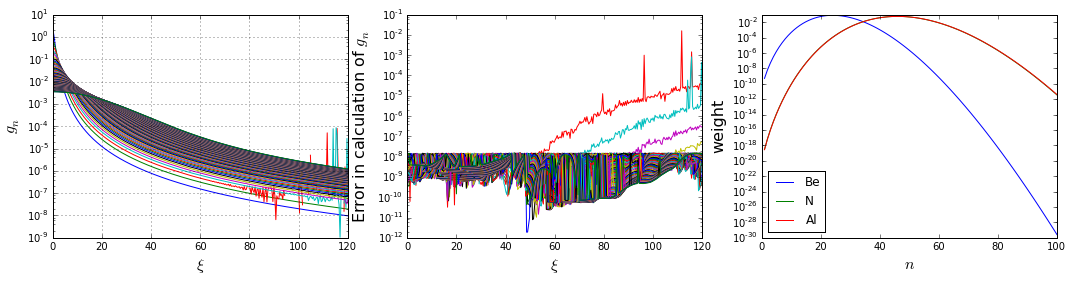

In [166]:
plt.figure(figsize=(18.0,4.0))
plt.subplot(131)
plt.semilogy(normAngl,gn)
plt.grid(axis='both')
plt.xlabel(r'$\xi$',size=16)
plt.ylabel(r'$g_n$',size=16)
plt.subplot(132)
plt.semilogy(normAngl,erro)
plt.xlabel(r'$\xi$',size=16)
plt.ylabel(r'Error in calculation of $g_n$',size=16)
plt.subplot(133)
weight = np.zeros(n)
keys = ('Be','N','Al')
for key in keys:
    chi[key], lamb[key] = foil_prop(key)
    for i in range(n):
        weight[i] = get_weight(lamb[key],i+1)
    plt.semilogy(np.arange(1,n+1),weight,label=key)
plt.legend(loc='best')
plt.xlabel(r'$n$',size=16)
plt.ylabel(r'weight',size=16)
plt.show()

With that in mind, knowing the value of our $\lambda$ we can calculated the angular distribution ($f_n(\theta,\lambda)$) truncated in $n$:

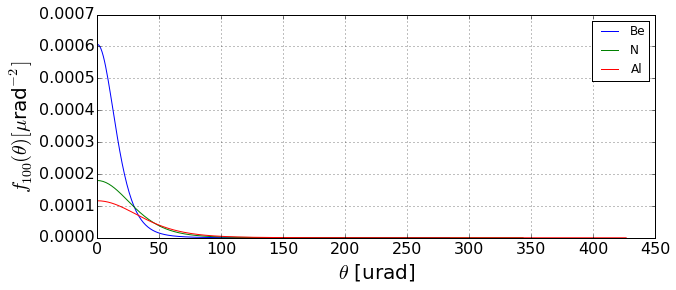

In [167]:
plt.figure(figsize=(10.0,4.0))

keys = ('Be','N','Al')
for key in keys:
    angl[key]  = normAngl * chi[key]
    distr[key] = distribution(normAngl, lamb[key], chi[key])
    plt.plot(angl[key]*1e6,distr[key]*1e-12,label=key)

plt.legend(loc='best')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel(r'$\theta$ [urad]',size=20)
plt.ylabel(r'$f_{{{0:d}}}(\theta) [\mu $rad$^{{-2}}]$'.format(n),size=20)
plt.grid(axis='both')
plt.show()

In order to check the the convergence of the truncated distribution, we verify if its normalization: $$
||f|| = \int f(\theta,\lambda) \text{d}\Omega \approx
2\pi\int_0^\infty \theta f(\theta,\lambda) \text{d}\theta
$$ is close enough to unity:

In [168]:
label = r"""\begin{eqnarray}"""

keys = ('Be','N','Al')
for key in keys:
    norma[key]  = 2*np.pi*np.trapz(distr[key]*angl[key],x=angl[key])
    label += r"""||f||_{{{0:2s}}} &=& {{{1:7.5f}}}\\ """.format(key,norma[key])

Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

it is possible to calculate the first and second moments of the distribution:
$$\langle\theta\rangle = \int_0^\infty \theta f(\theta,\lambda) \text{d}\Omega,\quad 
\langle\theta^2\rangle = \int_0^\infty \theta^2 f(\theta,\lambda) \text{d}\Omega$$

In [169]:
label = r"""\begin{eqnarray}"""
for key in keys:
    media[key]  = 2*np.pi*np.trapz(angl[key]**2*distr[key],x=angl[key])
    desvio[key] = 2*np.pi*np.trapz(angl[key]**3*distr[key],x=angl[key])
    label += r"""\langle\theta\rangle_{{{0:2s}}} &=& {{{1:7.5f}}}\, \mu\text{{rad}}, \quad \langle\theta^2\rangle_{{{0:2s}}} &=& {2:7.5f}\, \mu\text{{rad}}^2\\ """.format(key,media[key]*1e6, np.sqrt(desvio[key]*1e12/2))
Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

## Double Layer Scattering

According to the paper, the angular distribution of a beam with initial angular distribution $h_0(\theta)$ after passing througth the window is given by the convolution:

\begin{equation}
h_1(\theta,\lambda) = \int_0^\infty \text{d}\theta'\, \theta'h_0(\theta')\int_0^{2\pi} \text{d}\phi \, f(\theta'',\lambda) 
\quad \text{with} \quad \theta'' = \sqrt{\theta'^2 + \theta^2 - 2\theta'\theta\cos(\phi)}
\end{equation}
where $\theta'$ is the incoming azimuthal angle, $\theta''$ is the scattered azimuthal angle, $\phi$ is the difference between the initial and scattered polar angles and $\theta$ is the final angle.
Analogously, to obtain the double layer scattering distribution for a parallel beam, we must convolve:

\begin{equation}
f(\theta) = \int_0^\infty \text{d}\theta'\, \theta'f_1(\theta',\lambda_1)\int_0^{2\pi} \text{d}\phi \, f_2(\theta'',\lambda_2).
\end{equation}

Lets define this convolution:

In [170]:
# Convolution in theta and phi representation
def convolve(x,func1,func2):
    #integral in angle phi
    def fun2(x2,xl2, func):
        phi  = np.linspace(0,2*np.pi,200)
        ret2 = np.zeros(xl2.shape)
        for i in range(len(xl2)):
            ret2[i] = np.trapz(func(np.sqrt(xl2[i]**2 + x2**2 - 2*x2*xl2[i]*np.cos(phi))),x=phi)
        return ret2
    
    #Integral in theta'
    xl  = x.copy()
    ret = np.zeros(x.shape)
    for i in range(len(x)):
        ret[i] = np.trapz(xl*func1(xl)*fun2(x[i],xl,func2),x=xl)
    return ret

Now we can calculate the angular distribution of the convolution:

In [171]:
#### this cell takes 16s to run #####
# Aluminum and air
distN  = lambda x : np.interp(x,angl['N'],distr['N'],left=0.0,right=0.0)
distAl = lambda x : np.interp(x,angl['Al'],distr['Al'],left=0.0,right=0.0)
angl['Al-N']    = angl['N']
distr['Al-N']   = convolve(angl['Al-N'],distAl,distN)


# Berilium and air
distBe = lambda x : np.interp(x,angl['Be'],distr['Be'],left=0.0,right=0.0)
angl['Be-N']    = angl['N']
distr['Be-N']   = convolve(angl['Be-N'],distBe,distN)

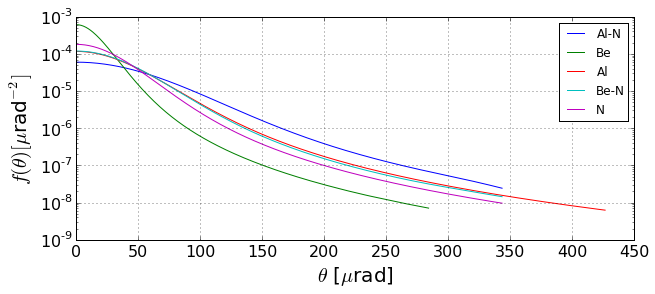

In [172]:
plt.figure(figsize=(10.0,4.0))
for key in distr.keys():
    plt.semilogy(angl[key]*1e6,distr[key]*1e-12,label=key)
plt.legend(loc='best')
plt.grid(axis='both')
plt.tick_params(labelsize=16)
plt.xlabel(r'$\theta$ [$\mu$rad]',fontsize=20)
plt.ylabel(r'$f(\theta) [\mu $rad$^{-2}]$',fontsize=20)
plt.show()

And look at its normalization and first moments:

In [173]:
label = r"""\begin{eqnarray}"""

norma['Al-N'] = 2*np.pi*np.trapz(distr['Al-N']*angl['Al-N'],x=angl['Al-N'])
label += r"""||f||_{{{0:3s}}} &=& {{{1:7.5f}}}\\ """.format('Al-N',norma['Al-N'])

norma['Be-N'] = 2*np.pi*np.trapz(distr['Be-N']*angl['Be-N'],x=angl['Be-N'])
label += r"""||f||_{{{0:3s}}} &=& {{{1:7.5f}}}\\ """.format('Be-N',norma['Be-N'])

Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

In [174]:
label = r"""\begin{eqnarray}"""

media['Al-N']  = 2*np.pi*np.trapz(angl['Al-N']**2*distr['Al-N'],x=angl['Al-N'])
desvio['Al-N'] = 2*np.pi*np.trapz(angl['Al-N']**3*distr['Al-N'],x=angl['Al-N'])
label += r"""\langle\theta\rangle_{{{0:3s}}} &=& {{{1:7.1f}}}\, \mu\text{{rad}}, \quad \langle\theta^2\rangle_{{{0:3s}}} &=& {2:7.1f}\, \mu\text{{rad}}^2\\ """.format('Al-N',media['Al-N']*1e6, desvio['Al-N']*1e12)

media['Be-N']  = 2*np.pi*np.trapz(angl['Be-N']**2*distr['Be-N'],x=angl['Be-N'])
desvio['Be-N'] = 2*np.pi*np.trapz(angl['Be-N']**3*distr['Be-N'],x=angl['Be-N'])
label += r"""\langle\theta\rangle_{{{0:3s}}} &=& {{{1:7.1f}}}\, \mu\text{{rad}}, \quad \langle\theta^2\rangle_{{{0:3s}}} &=& {2:7.1f}\, \mu\text{{rad}}^2\\ """.format('Be-N',media['Be-N']*1e6, desvio['Be-N']*1e12)

Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

Notice that:

\begin{eqnarray}
\langle\theta\rangle_{AlN}^2 &\approx \langle\theta\rangle_{Al}^2 + \langle\theta\rangle_{N}^2 \quad\quad \text{and}\quad\quad
\langle\theta^2\rangle_{AlN} &\approx \langle\theta^2\rangle_{Al} + \langle\theta^2\rangle_{N} \\
\langle\theta\rangle_{BeN}^2 &\approx \langle\theta\rangle_{Be}^2 + \langle\theta\rangle_{N}^2 \quad\quad\text{and}\quad\quad
\langle\theta^2\rangle_{BeN} &\approx \langle\theta^2\rangle_{Be} + \langle\theta^2\rangle_{N} 
\end{eqnarray}

## Convolution with the Beam:

We know the electron beam posses a gaussian shape in both transverse phase spaces:

\begin{equation}
h(\theta_x,\theta_y) = \frac{1}{2\pi\sigma_{\theta_x}\sigma_{\theta_y}}\exp\left(-\frac{\theta_x^2}{2\sigma_{\theta_x}^2} -\frac{\theta_y^2}{2\sigma_{\theta_y}^2}\right)
\end{equation}

The first thing we need to do is to find a relationship between $(\theta, \phi)$ representation and the $(\theta_x,\theta_y)$ representation.

Looking at the figure below:

<img src="coordinate_system.svg" />

we can see that:

\begin{equation}
\left.
\begin{aligned}
\tan(\theta_x) &= \frac{\overline{OX}}{\overline{OZ}} =
\frac{\overline{OC}\cos(\phi)}{\overline{OP}\cos(\theta)} = 
\frac{\overline{OP}\sin(\theta)\cos(\phi)}{\overline{OP}\cos(\theta)} = \tan(\theta)\cos(\phi) \\
\tan(\theta_y) &= \frac{\overline{OY}}{\overline{OZ}} =
\frac{\overline{OC}\sin(\phi)}{\overline{OP}\cos(\theta)} =
\frac{\overline{OP}\sin(\theta)\sin(\phi)}{\overline{OP}\cos(\theta)} = \tan(\theta)\sin(\phi)
\end{aligned}
\right\} \Rightarrow
\begin{aligned}
\theta_x &\approx \theta\cos(\phi) \\
\theta_y &\approx \theta\sin(\phi)
\end{aligned}
\end{equation}

This way, we can easily express the distribution in polar coordinates:

\begin{equation}
||h|| = \int_{-\infty}^\infty \!\!\!\!\!\text{d}\theta_y \int_{-\infty}^\infty \!\!\!\!\!\text{d}\theta_x h(\theta_x,\theta_y) = 
\int_0^{2\pi} \!\!\!\!\!\text{d}\phi \int_0^\infty \!\!\!\!\!\text{d}\theta\,\, \theta h(\theta,\phi) = 1
\end{equation}

### Round Beam:

Assuming $\sigma_{\theta_x} = \sigma_{\theta_y}$, the beam distribution will not depend on $\phi$, and we can define:

\begin{equation}
h(\theta) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\theta^2}{2\sigma^2}\right) \Rightarrow ||h|| = 2\pi\int_0^\infty \!\!\!\!\!\text{d}\theta \,\theta h(\theta) = 1
\end{equation}

The first and second moments of this distribution are given by:

In [175]:
theta = sigx*np.linspace(0,6,1000)
h0 = lambda x,sigma: 1/(2*np.pi*sigma**2)*np.exp(-x**2/(2*sigma**2))

label = r"""\begin{equation}"""
norm  = 2*np.pi*np.trapz(theta   *h0(theta,sigx),x=theta)
medi  = 2*np.pi*np.trapz(theta**2*h0(theta,sigx),x=theta)/sigx/np.sqrt(np.pi/2)
desvi = 2*np.pi*np.trapz(theta**3*h0(theta,sigx),x=theta)/(2*sigx**2)
label += r"""||h|| = {0:7.5f},\quad \frac{{\langle\theta\rangle}}{{\sqrt\frac\pi2\sigma}} = {1:7.5f}\,, \quad \frac{{\langle\theta^2\rangle}}{{2\sigma^2}} = {2:7.5f}""".format(norm,medi, desvi)
Latex(label+r"""\end{equation}""")

<IPython.core.display.Latex object>

Doing the convolution of the initial beam distribution with the previous results we obtain:

In [176]:
#### this cell takes 32s to run #####
# convolution with Al-N window
dist   = lambda x : np.interp(x,angl['Al-N'],distr['Al-N'],left=0.0,right=0.0)
h      = lambda x : h0(x,sigx)
angl['RBx-Al-N']   = angl['Al-N']
distr['RBx-Al-N']  = convolve(angl['RBx-Al-N'],h,dist)
h      = lambda x : h0(x,sigy)
angl['RBy-Al-N']   = angl['Al-N']
distr['RBy-Al-N']  = convolve(angl['RBy-Al-N'],h,dist)

# convolution with Be-N window
dist   = lambda x : np.interp(x,angl['Be-N'],distr['Be-N'],left=0.0,right=0.0)
h      = lambda x : h0(x,sigx)
angl['RBx-Be-N']   = angl['Be-N']
distr['RBx-Be-N']  = convolve(angl['RBx-Be-N'],h,dist)
h      = lambda x : h0(x,sigy)
angl['RBy-Be-N']   = angl['Be-N']
distr['RBy-Be-N']  = convolve(angl['RBy-Be-N'],h,dist)

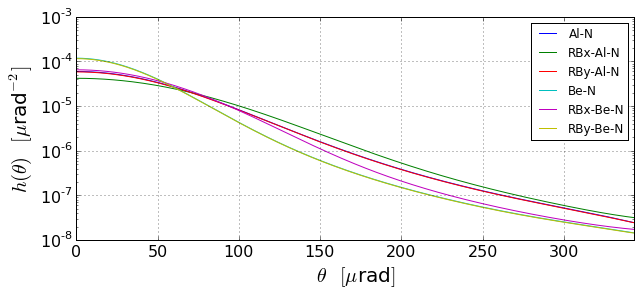

In [177]:
plt.figure(figsize=(10.0,4.0))
for key in ('Al-N','RBx-Al-N','RBy-Al-N','Be-N','RBx-Be-N','RBy-Be-N'):
    plt.semilogy(angl[key]*1e6,distr[key]*1e-12,label=key)
plt.xlim(0,angl[key][-1]*1e6)
plt.tick_params(labelsize=16)
plt.xlabel(r'$\theta \,\,[\mu$rad$]$',fontsize=20)
plt.ylabel(r'$h(\theta) \,\,[\mu$rad$^{-2}]$',fontsize=20)
plt.legend(loc='best')
plt.grid(axis='both')
plt.show()

In [178]:
label = r"""\begin{eqnarray}"""
for key in ('RBx-Al-N','RBy-Al-N','RBx-Be-N','RBy-Be-N'):
    norma[key] = 2*np.pi*np.trapz(distr[key]*angl[key],x=angl[key])
    label += r"""||h||_{{{0:3s}}} &=& {{{1:7.5f}}}\\ """.format(key,norma[key])

Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

In [179]:
label    = r"""\begin{eqnarray}"""
for key in ('RBx-Al-N','RBy-Al-N','RBx-Be-N','RBy-Be-N'):
    media[key] = 2*np.pi*np.trapz(angl[key]**2*distr[key],x=angl[key])
    desvio[key]= 2*np.pi*np.trapz(angl[key]**3*distr[key],x=angl[key])
    label   += r"""\langle\theta\rangle_{{{0:3s}}} &=& {{{1:7.5f}}}\, \mu\text{{rad}}, \quad \langle\theta^2\rangle_{{{0:3s}}} &=& {2:7.5f}\, \mu\text{{rad}}^2\\ """.format(key,media[key]*1e6, desvio[key]*1e12)

Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

Notice that:

\begin{eqnarray}
\langle\theta\rangle_{RB-Al-N}^2 &\approx& \langle\theta\rangle_{Al-N}^2 + \langle\theta\rangle_{RB}^2
\quad\quad\text{and}\quad\quad
\langle\theta^2\rangle_{RB-Al-N} &\approx& \langle\theta^2\rangle_{Al-N} + \langle\theta^2\rangle_{RB} \\
\langle\theta\rangle_{RB-Be-N}^2 &\approx& \langle\theta\rangle_{Be-N}^2 + \langle\theta\rangle_{RB}^2
\quad\quad\text{and}\quad\quad
\langle\theta^2\rangle_{RB-Be-N} &\approx& \langle\theta^2\rangle_{Be-N} + \langle\theta^2\rangle_{RB} 
\end{eqnarray}

The figures below show a comparison between the total convoluted distribution with a Gaussian Distribution with $\sigma$ given by the rule:

$$ \sigma = \frac{\langle\theta\rangle}{\sqrt\frac\pi2}$$

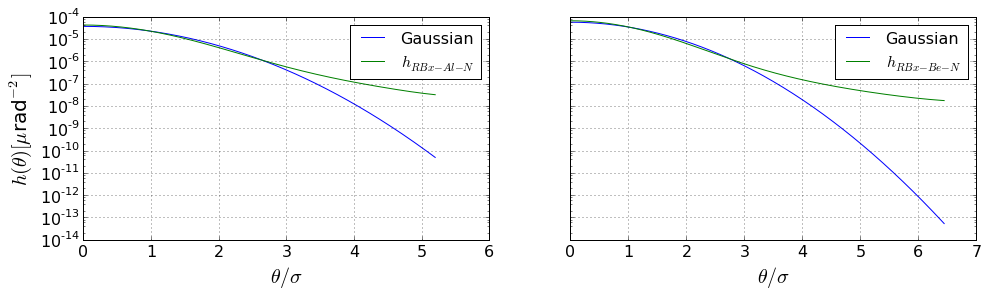

In [180]:
fig,ax = plt.subplots(1,2, sharey=True,figsize=(16.0,4.0))
ax[0].tick_params(labelsize=16)
sig = media['RBx-Al-N']/np.sqrt(np.pi/2)
ax[0].semilogy(angl['RBx-Al-N']/sig,h0(angl['RBx-Al-N'],sig)*1e-12,label='Gaussian')
ax[0].semilogy(angl['RBx-Al-N']/sig,distr['RBx-Al-N']*1e-12,label=r'$h_{RBx-Al-N}$')
ax[0].set_xlabel(r'$\theta / \sigma$',fontsize=20)
ax[0].set_ylabel(r'$h(\theta) [\mu$rad$^{-2}]$',fontsize=20)
ax[0].legend(loc='best',fontsize=16)
ax[0].grid(axis='both')
ax[0].tick_params(labelsize=16)
sig = media['RBx-Be-N']/np.sqrt(np.pi/2)
ax[1].semilogy(angl['RBx-Be-N']/sig,h0(angl['RBx-Be-N'],sig)*1e-12,label='Gaussian')
ax[1].semilogy(angl['RBx-Be-N']/sig,distr['RBx-Be-N']*1e-12,label=r'$h_{RBx-Be-N}$')
ax[1].set_xlabel(r'$\theta / \sigma$',fontsize=20)
ax[1].legend(loc='best',fontsize=16)
ax[1].grid(axis='both')
ax[1].tick_params(labelsize=16)
fig.show()

### Elliptical Beam:

In the case the beam is not round, it is easy to do the convolution in the $(\theta_x,\theta_y)$ representation. In this coordinate system, each initial point $(\theta'_x,\theta'_y)$  can be taken to another point $(\theta_x,\theta_y)$ with a probability $f\left(\sqrt{(\theta_x-\theta'_x)^2 + (\theta_y-\theta'_y)^2}\right)$. This way, the final distribution will be the sum of the contribution of all points $(\theta'_x,\theta'_y)$ to each point $(\theta_x,\theta_y)$:

\begin{equation}
h(\theta_x,\theta_y) = 
\int_{-\infty}^\infty \!\!\!\!\! \text{d}\theta'_x 
\int_{-\infty}^\infty \!\!\!\!\! \text{d}\theta'_y \,\,
h_0(\theta'_x,\theta'_y)f\left(\sqrt{(\theta_x-\theta'_x)^2 + (\theta_y-\theta'_y)^2}\right) 
\end{equation}


In [314]:
def h0xy(x,sigmax,y,sigmay):
    x = np.array(x).ravel()[None,:]
    y = np.array(y).ravel()[:,None]
    return 1/(2*np.pi*sigmax*sigmay)*np.exp(-x**2/(2*sigmax**2)-y**2/(2*sigmay**2))

 # convert distribution in theta to thetax and thetay
def ThetaPhi2XY(x,y, dit):
    x = np.array(x).ravel()[None,:]
    y = np.array(y).ravel()[:,None]
    return np.interp(np.sqrt(x**2+y**2),angl['N'],dit,left=0.0,right=0.0)

In [182]:
xx      = np.linspace(-1,1,601)*angl['N'][-1]
yy      = np.linspace(-1,1,601)*angl['N'][-1]
X,Y     = np.meshgrid(xx,yy)
angl['EB']       = (xx,yy)
distr['EB']      = h0xy(xx,sigx,yy,sigy)
diAlN            = ThetaPhi2XY(xx,yy,distr['Al-N'])
angl['EB-Al-N']  = (xx,yy)
distr['EB-Al-N'] = scysig.fftconvolve(distr['EB'],diAlN,mode='same')*(xx[1]-xx[0])*(yy[1]-yy[0])
diBeN            = ThetaPhi2XY(xx,yy,distr['Be-N'])
angl['EB-Al-N']  = (xx,yy)
distr['EB-Be-N'] = scysig.fftconvolve(distr['EB'],diBeN,mode='same')*(xx[1]-xx[0])*(yy[1]-yy[0])

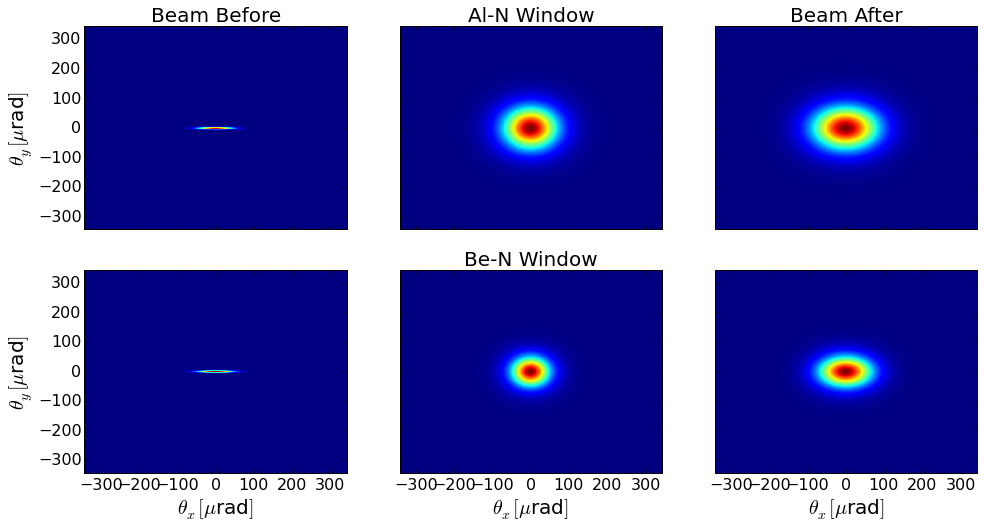

In [183]:
fig, ax = plt.subplots(2,3,sharey=True,sharex=True)
fig.set_size_inches(16,8)
ax[0,0].set_xlim([xx.min()*1e6,xx.max()*1e6])
ax[0,0].set_ylim([yy.min()*1e6,yy.max()*1e6])
ax[0,0].set_ylabel(r'$\theta_y [\mu$rad$]$',fontsize=20)
ax[1,0].set_ylabel(r'$\theta_y [\mu$rad$]$',fontsize=20)
Z     = ((distr['EB'],distr['EB']),(diAlN,diBeN),(distr['EB-Al-N'],distr['EB-Be-N']))
title = (('Beam Before',''),('Al-N Window','Be-N Window'),('Beam After',''))
for j in range(3):
    ax[1,j].set_xlabel(r'$\theta_x [\mu$rad$]$',fontsize=20)
    for i in range(2):
        ax[i,j].set_title(title[j][i],fontsize=20)
        ax[i,j].pcolormesh(X*1e6,Y*1e6,Z[j][i]*1e-12)
        ax[i,j].tick_params(labelsize=16)
plt.show()

In [184]:
label = r"""\begin{eqnarray}"""

norma['EB-Al-N'] = np.trapz(np.trapz(distr['EB-Al-N'],x=yy,axis=0),x=xx)
label += r"""||h||_{{{0:3s}}} &=& {{{1:7.5f}}}\\ """.format('EB-Be-N',norma['EB-Al-N'])

norma['EB-Be-N'] = np.trapz(np.trapz(distr['EB-Be-N'],x=xx,axis=1),x=yy)
label += r"""||h||_{{{0:3s}}} &=& {{{1:7.5f}}}\\ """.format('EB-Be-N',norma['EB-Be-N'])

Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

In [185]:
label    = r"""\begin{eqnarray}"""
mex = np.trapz(np.trapz(X*distr['EB-Al-N'],x=yy,axis=0),x=xx)
mey = np.trapz(np.trapz(Y*distr['EB-Al-N'],x=xx,axis=1),x=yy)
media['EB-Al-N']  = (mex,mey)
dex = np.sqrt(np.trapz(np.trapz(X**2*distr['EB-Al-N'],x=yy,axis=0),x=xx))
dey = np.sqrt(np.trapz(np.trapz(Y**2*distr['EB-Al-N'],x=xx,axis=1),x=yy))
desvio['EB-Al-N'] = (dex**2,dey**2)
label   += r"""\sqrt{{\langle\theta_x^2\rangle_{{{0:3s}}}}} &=& {{{1:7.5f}}}\, \mu\text{{rad}}, \quad \sqrt{{\langle\theta_y^2\rangle_{{{0:3s}}}}} &=& {2:7.5f}\, \mu\text{{rad}}^2\\ """.format('EB-Al-N',dex*1e6, dey*1e6)
mex = np.trapz(np.trapz(X*distr['EB-Be-N'],x=yy,axis=0),x=xx)
mey = np.trapz(np.trapz(Y*distr['EB-Be-N'],x=xx,axis=1),x=yy)
media['EB-Be-N']  = (mex,mey)
dex = np.sqrt(np.trapz(np.trapz(X**2*distr['EB-Be-N'],x=yy,axis=0),x=xx))
dey = np.sqrt(np.trapz(np.trapz(Y**2*distr['EB-Be-N'],x=xx,axis=1),x=yy))
desvio['EB-Be-N'] = (dex**2,dey**2)
label   += r"""\sqrt{{\langle\theta_x^2\rangle_{{{0:3s}}}}} &=& {{{1:7.5f}}}\, \mu\text{{rad}}, \quad \sqrt{{\langle\theta_y^2\rangle_{{{0:3s}}}}} &=& {2:7.5f}\, \mu\text{{rad}}^2\\ """.format('EB-Be-N',dex*1e6, dey*1e6)

Latex(label[0:-3]+r"""\end{eqnarray}""")

<IPython.core.display.Latex object>

## Numerical Simulations

We have simulated the scattering in Fluka. We hit the window with a non-divergent beam and look at the beam size at a distance $L$ from the source, as shown in the figure bellow:

<img src='Simulation_scheme.svg'>

To get the beam divergence we divide the scales of the detector by the length $L$. To gain precision, we have set the distance $L$ to $3$m and the initial beam is a 2D gaussian with full width half maximum equal to $1\mu\text{m}\times1\mu\text{m}$. We simulated transported $640000$ particles.

The simulations were performed in a Ubuntu virtual machine with the aid of Flair to prepare the inputs for Fluka and process the outputs. The result Flair gives us is a *.txt* file with four coluns, whose meanings are:

$x$ [cm] | $y$ [cm] | $f_n$ [$\frac{1}{\text{cm}^2}$] | Err$(f_n)$ [%]
-|
| | |

where $(x,y)$ represents the transverse grid ($x$ varies slower in the data), $f_n$ is the frequency distribution of the electrons in each point of the grid and Err$(f_n)$ is the error in the calculation of the frequency distribution function.

### Berilium - Air:

In [328]:
#dados = np.loadtxt('FlukaSimulation/Ric_electron_scattering_79_plot.dat')
dados = np.loadtxt('FlukaSimulation/Be12umAir5cm.dat')
#dados = np.loadtxt('FlukaSimulation/Be12um.dat')
L = 299 # cm
nly = np.unique(dados[:,0]).shape[0]
nlx = len(dados)//nly
X = dados[:,0].reshape([nly,nlx]).T/L#*1e-2#
Y = dados[:,1].reshape([nly,nlx]).T/L
angl['Simul-Be-Air']  = (X[0,:].ravel(),Y[:,0].ravel())
distr['Simul-Be-Air'] = dados[:,2].reshape([nly,nlx])*L**2#*1e4#
err  = dados[:,3].reshape([nly,nlx])

#chi['CalcBe'],lamb['CalcBe'] = foil_prop('Al')#,thick=1e-2)
#distr['CalcBe']   = distribution(np.sqrt(X**2+Y**2)/chi['CalcBe'],lamb['CalcBe'],chi['CalcBe'])
#diAlN = dist(X[0,:].ravel(),Y[:,0].ravel(),distr['Al-N'])
diBeN = ThetaPhi2XY(X[0,:].ravel(),Y[:,0].ravel(),distr['Be-N'])

<IPython.core.display.Latex object>

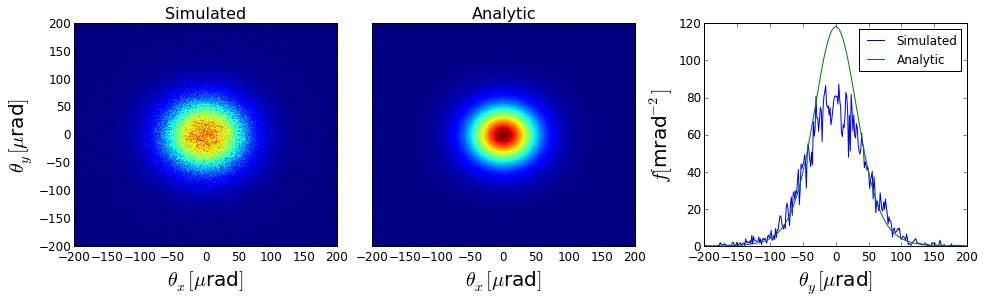

In [331]:
key = 'Simul-Be-Air'
fig = plt.figure(figsize=(16.0,4.0)) 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Simulated', fontsize=16)
ax1.pcolormesh(X*1e6,Y*1e6,distr[key])
ax1.set_xlabel(r'$\theta_x [\mu$rad$]$',fontsize=20)
ax1.set_ylabel(r'$\theta_y [\mu$rad$]$',fontsize=20)
ax1.set_xlim(200*np.array([-1,1]))
ax1.set_ylim(200*np.array([-1,1]))
ax1.tick_params(labelsize=12)

ax2 = plt.subplot(1,3,2)
ax2.set_title('Analytic', fontsize=16)
a = ax2.get_position()
ax2.set_position([a.x0-0.015,a.y0,a.width,a.height])
ax2.pcolormesh(X*1e6,Y*1e6,diBeN)
ax2.set_xlabel(r'$\theta_x [\mu$rad$]$',fontsize=20)
ax2.set_yticklabels('',visible=False)
ax2.set_xlim(200*np.array([-1,1]))
ax2.set_ylim(200*np.array([-1,1]))
ax2.tick_params(labelsize=12)

ax3 = plt.subplot(1,3,3)
ax3.plot(Y[:,nly//2+1] * 1e6,distr[key][:,nly//2+1]*1e-6,label='Simulated')
ax3.plot(Y[:,nly//2+1] * 1e6,diBeN[:,nly//2+1]*1e-6,label='Analytic')
plt.legend(loc='best')
ax3.set_xlim(200*np.array([-1,1]))
ax3.set_xlabel(r'$\theta_y [\mu$rad$]$',fontsize=20)
ax3.set_ylabel(r'$f [$mrad$^{-2}]$',fontsize=20)
ax3.tick_params(labelsize=12)

fig.show()

label = r"""\begin{eqnarray}"""
norma[key]     = np.trapz(np.trapz(distr[key],x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mex      = np.trapz(np.trapz(X*distr[key],x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mey      = np.trapz(np.trapz(Y*distr[key],x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel())
desvio[key]    = [0,0]
desvio[key][0] = np.sqrt(np.trapz(np.trapz(X**2*distr[key],x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel()) -mex**2)
desvio[key][1] = np.sqrt(np.trapz(np.trapz(Y**2*distr[key],x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel()) -mey**2)
label += r"""\text{{Simulated}}: &||f|| = {0:7.5f},\quad \sigma_{{\theta_x}} = {1:7.5f}\,, \quad \sigma_{{\theta_y}} = {2:7.5f}\\""".format(norma[key],desvio[key][0]*1e6, desvio[key][1]*1e6)

no = np.trapz(np.trapz(diBeN,x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mex = np.trapz(np.trapz(X*diBeN,x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mey = np.trapz(np.trapz(Y*diBeN,x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel())
dex = np.sqrt(np.trapz(np.trapz(X**2*diBeN,x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel()) -(mey)**2)
dey = np.sqrt(np.trapz(np.trapz(Y**2*diBeN,x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel()) -(mex)**2)
label += r"""\text{{Analytic}}: &||f|| = {0:7.5f},\quad \sigma_{{\theta_x}} = {1:7.5f}\,, \quad \sigma_{{\theta_y}} = {2:7.5f}""".format(no,dex*1e6, dey*1e6)

norm  = 2*np.pi*np.trapz(theta   *h0(theta,sigx),x=theta)
medi  = 2*np.pi*np.trapz(theta**2*h0(theta,sigx),x=theta)/sigx/np.sqrt(np.pi/2)
desvi = 2*np.pi*np.trapz(theta**3*h0(theta,sigx),x=theta)/(2*sigx**2)

Latex(label+r"""\end{eqnarray}""")

### Aluminium - Air:

In [332]:
dados = np.loadtxt('FlukaSimulation/Al10umAir5cm.dat')
L = 299 # cm
nly = np.unique(dados[:,0]).shape[0]
nlx = len(dados)//nly
X = dados[:,0].reshape([nly,nlx]).T/L#*1e-2#
Y = dados[:,1].reshape([nly,nlx]).T/L
angl['Simul-Al-Air']  = (X[0,:].ravel(),Y[:,0].ravel())
distr['Simul-Al-Air'] = dados[:,2].reshape([nly,nlx])*L**2#*1e4#
err  = dados[:,3].reshape([nly,nlx])

diAlN = ThetaPhi2XY(X[0,:].ravel(),Y[:,0].ravel(),distr['Al-N'])

<IPython.core.display.Latex object>

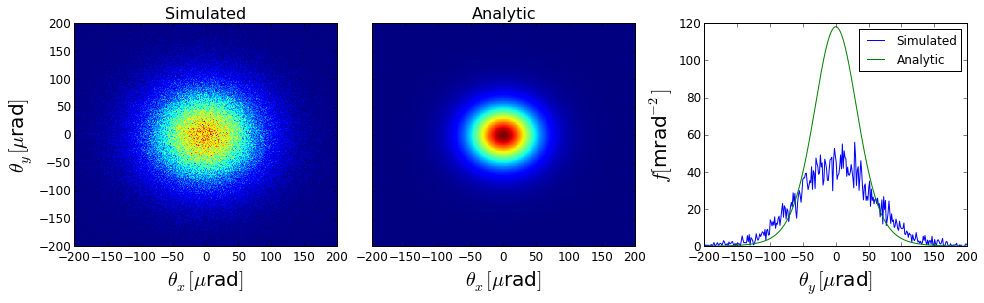

In [335]:
key = 'Simul-Al-Air'
fig = plt.figure(figsize=(16.0,4.0)) 

ax1 = plt.subplot(1,3,1)
ax1.set_title('Simulated', fontsize=16)
ax1.pcolormesh(X*1e6,Y*1e6,distr[key])
ax1.set_xlabel(r'$\theta_x [\mu$rad$]$',fontsize=20)
ax1.set_ylabel(r'$\theta_y [\mu$rad$]$',fontsize=20)
ax1.set_xlim(200*np.array([-1,1]))
ax1.set_ylim(200*np.array([-1,1]))
ax1.tick_params(labelsize=12)

ax2 = plt.subplot(1,3,2)
ax2.set_title('Analytic', fontsize=16)
a = ax2.get_position()
ax2.set_position([a.x0-0.015,a.y0,a.width,a.height])
ax2.pcolormesh(X*1e6,Y*1e6,diBeN)
ax2.set_xlabel(r'$\theta_x [\mu$rad$]$',fontsize=20)
ax2.set_yticklabels('',visible=False)
ax2.set_xlim(200*np.array([-1,1]))
ax2.set_ylim(200*np.array([-1,1]))
ax2.tick_params(labelsize=12)

ax3 = plt.subplot(1,3,3)
ax3.plot(Y[:,nly//2+1] * 1e6,distr[key][:,nly//2+1]*1e-6,label='Simulated')
ax3.plot(Y[:,nly//2+1] * 1e6,diBeN[:,nly//2+1]*1e-6,label='Analytic')
plt.legend(loc='best')
ax3.set_xlim(200*np.array([-1,1]))
ax3.set_xlabel(r'$\theta_y [\mu$rad$]$',fontsize=20)
ax3.set_ylabel(r'$f [$mrad$^{-2}]$',fontsize=20)
ax3.tick_params(labelsize=12)

fig.show()


label = r"""\begin{eqnarray}"""
norma[key]     = np.trapz(np.trapz(distr[key],x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mex      = np.trapz(np.trapz(X*distr[key],x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mey      = np.trapz(np.trapz(Y*distr[key],x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel())
desvio[key]    = [0,0]
desvio[key][0] = np.sqrt(np.trapz(np.trapz(X**2*distr[key],x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel()) -mex**2)
desvio[key][1] = np.sqrt(np.trapz(np.trapz(Y**2*distr[key],x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel()) -mey**2)
label += r"""\text{{Simulated}}: &||f|| = {0:7.5f},\quad \sigma_{{\theta_x}} = {1:7.5f}\,, \quad \sigma_{{\theta_y}} = {2:7.5f}\\""".format(norma[key],desvio[key][0]*1e6, desvio[key][1]*1e6)

no = np.trapz(np.trapz(diAlN,x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mex = np.trapz(np.trapz(X*diAlN,x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel())
mey = np.trapz(np.trapz(Y*diAlN,x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel())
dex = np.sqrt(np.trapz(np.trapz(X**2*diAlN,x=X[0,:].ravel(),axis=1),x=Y[:,0].ravel()) -(mey)**2)
dey = np.sqrt(np.trapz(np.trapz(Y**2*diAlN,x=Y[:,0].ravel(),axis=0),x=X[0,:].ravel()) -(mex)**2)
label += r"""\text{{Analytic}}: &||f|| = {0:7.5f},\quad \sigma_{{\theta_x}} = {1:7.5f}\,, \quad \sigma_{{\theta_y}} = {2:7.5f}""".format(no,dex*1e6, dey*1e6)

norm  = 2*np.pi*np.trapz(theta   *h0(theta,sigx),x=theta)
medi  = 2*np.pi*np.trapz(theta**2*h0(theta,sigx),x=theta)/sigx/np.sqrt(np.pi/2)
desvi = 2*np.pi*np.trapz(theta**3*h0(theta,sigx),x=theta)/(2*sigx**2)

Latex(label+r"""\end{eqnarray}""")

We Notice that for both windowns, the amplitude of the distribution function at small angles is smaller in the simulation than in the analytic calculation, which could explain the smaller values for the standard deviation provided by the latter method.

The picture bellow shows the error, in percent, provided by Fluka in the calculation of the distribution function. For the area of interest for us, $(-100\mu\text{rad},100\mu\text{rad})$, the errors are acceptibles.

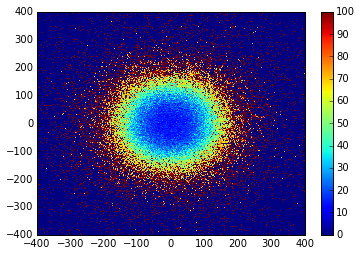

In [336]:
plt.pcolormesh(X*1e6,Y*1e6, np.abs(err))
plt.xlim(400*np.array([-1,1]))
plt.ylim(400*np.array([-1,1]))
plt.colorbar()
plt.show()